In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyale

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.model_selection import KFold, cross_val_score, ParameterGrid
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np
np.int = int
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.utils import shuffle
import shap
shap.initjs()
from PyALE import ale
from scipy.stats import friedmanchisquare
import itertools

In [5]:
#read input data
df_input = pd.read_csv('flow-cell.csv', index_col=0)

#filter input data
indices_to_remove_input = ['FE']
filtered_input = df_input.drop(indices_to_remove_input)
filtered_input = filtered_input.fillna(0) # fill  empty cells with 0
filtered_input = filtered_input.transpose() # change positions of columns and rows
filtered_input = filtered_input.loc[:, :'t [min]'] # remove columns after certain column
filtered_input = filtered_input.drop(['21065', '21090', '21091', '21097', '21092', '21080']) # remove outlier
filtered_input = filtered_input.drop(['21025', '21026', '21027', '21030', '21036']) # remove data without CE
#print(filtered_input)

#filter output data
df_output = pd.read_csv('flow-cell.csv', index_col=0)
filtered_output = df_output.loc['CE fuel [%]':, :,] # remove columns after certain column
filtered_output = filtered_output.fillna(0) # fill  empty cells with 0
filtered_output = filtered_output.transpose() # change positions of columns and rows
filtered_output = filtered_output.drop(['21065', '21090', '21091', '21097', '21092', '21080']) # remove outlier
filtered_output = filtered_output.drop(['21025', '21026', '21027', '21030', '21036']) # remove data without CE
#print(filtered_output)

output = 'CE fuel [%]'
output_name = 'CE [%]' # for correlation matrix
X = filtered_input.values
Y = filtered_output[output].values
print(Y)
features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']
short_feature_names = ['pH start', 'j', 'flow rate', 'time']

random_state_counter = 43
#print(filtered_input)

[39.95394913 29.8710028  33.17307987 31.63833069 25.95232457 28.27881488
 40.75113071 49.27574053 41.30722197 60.38526198 37.17859331 49.9029555
 43.94647658 25.64664369 29.47730903 33.70526117 80.21499496 54.96512072
 98.34395148 78.952637   51.1247465  53.68393062 34.45900134 34.1981107
 14.00039833 14.76655824 23.56966601 18.76801544 20.91861538 21.76319835
 50.23665221 33.20267464 24.11468499 40.46285238 15.92496257 35.70587124
 36.6342381  48.37068886 61.80860655 61.27621179 74.92355025 74.11791725
 71.91669707]


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_counter)
knn_regressor = Pipeline([
    ('scaler_std', StandardScaler()),
    ('scaler_minmax', MinMaxScaler()),  
    ('knn', KNeighborsRegressor(n_neighbors=10, weights='distance', p=1))
])


knn_regressor.fit(X_train, Y_train)

Y_predict_train_knn = knn_regressor.predict(X_train)
Y_predict_test_knn = knn_regressor.predict(X_test)


mse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn)
rmse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn, squared=False)
r2_train_knn = r2_score(Y_train, Y_predict_train_knn)

mse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn)
rmse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn, squared=False)
r2_test_knn = r2_score(Y_test, Y_predict_test_knn)

print("MSE on train set:", mse_train_knn )
print("RMSE on train set:", rmse_train_knn)
print("R2 on train set:", r2_train_knn)
print("MSE on test set:", mse_test_knn )
print("RMSE on test set:", rmse_test_knn)
print("R2 on test set:", r2_test_knn)

MSE on train set: 72.14757598435233
RMSE on train set: 8.493972921098367
R2 on train set: 0.8393376158140415
MSE on test set: 37.04802324070546
RMSE on test set: 6.086708736312709
R2 on test set: 0.7087525461578051


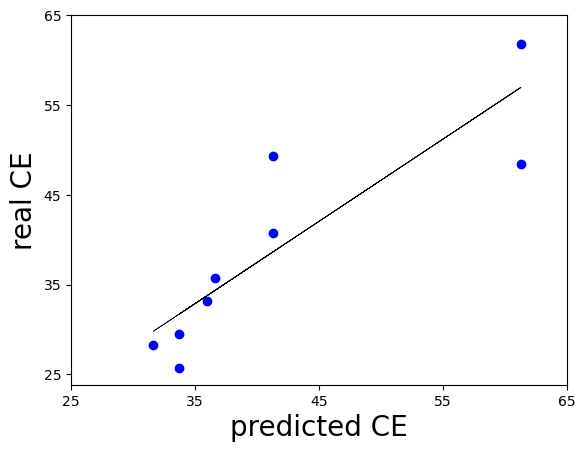

In [7]:
# Linear fit
slope, intercept = np.polyfit(Y_predict_test_knn, Y_test, 1)
fit_line = slope * Y_predict_test_knn + intercept

plt.plot(Y_predict_test_knn, fit_line, color='black', linestyle='-', label='Linear Fit', lw=0.5)
plt.scatter(Y_predict_test_knn, Y_test, color='blue', label='Scatter Points')
#plt.title('Scatter Plot of Y_train vs Y_test')
plt.xlabel('predicted CE', fontsize=20)
plt.ylabel('real CE', fontsize=20)
ticks_interval = 10
if int(min(Y_predict_test_knn)) > int(min(Y_test)):
    min_value = int(min(Y_test))
else:
    min_value = int(min(Y_predict_test_knn))
plt.xticks(np.arange(min_value, int(max(Y_predict_test_knn)) + 6, ticks_interval))
plt.yticks(np.arange(min_value, int(max(Y_test)) + 6, ticks_interval))
#plt.xlim([25, 63])  # Set x-axis range
#plt.ylim([25, 63])  # Set y-axis range
plt.show()

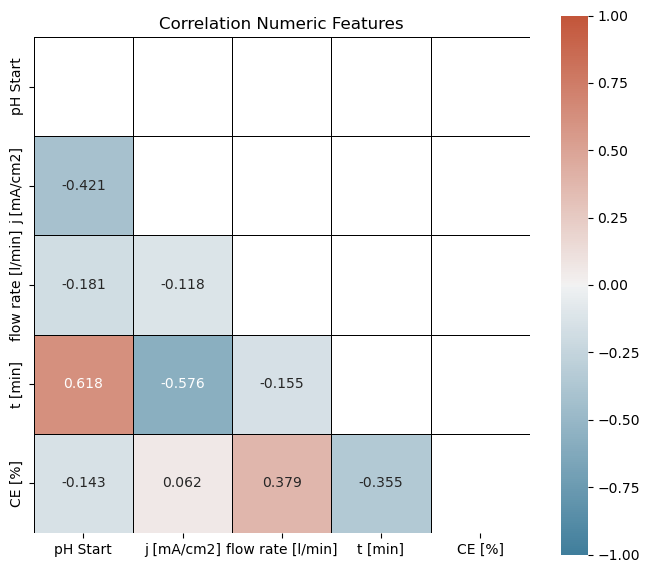

In [8]:
# correlation matrix
df_XY = filtered_input
df_XY[output_name] = filtered_output[output]

corr_df = df_XY.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)
ax.set(title='Correlation Numeric Features');

In [9]:
# SHAPLEY values
explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
instance_index = 7  # Replace with the index of the instance you want to explain
shap_value = explainer.shap_values(X_test[instance_index])
shap.force_plot(explainer.expected_value, shap_value, X_test[instance_index], feature_names=feature_names)

100%|██████████| 43/43 [00:00<00:00, 157.04it/s]


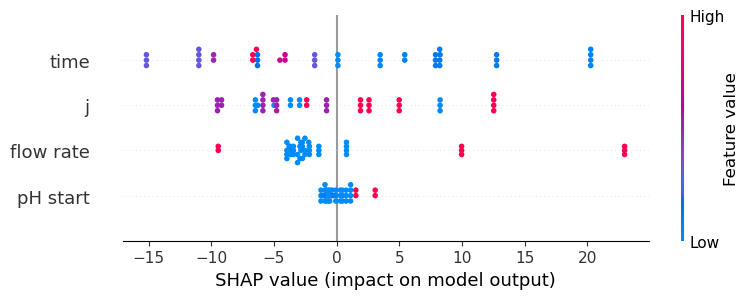

In [10]:
explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
shap_data = X
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data, feature_names=short_feature_names)

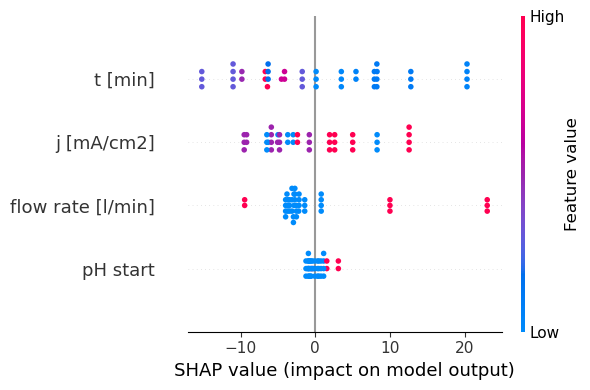

In [11]:
shap.summary_plot(shap_values, shap_data, feature_names=feature_names, plot_size = (6, 3))

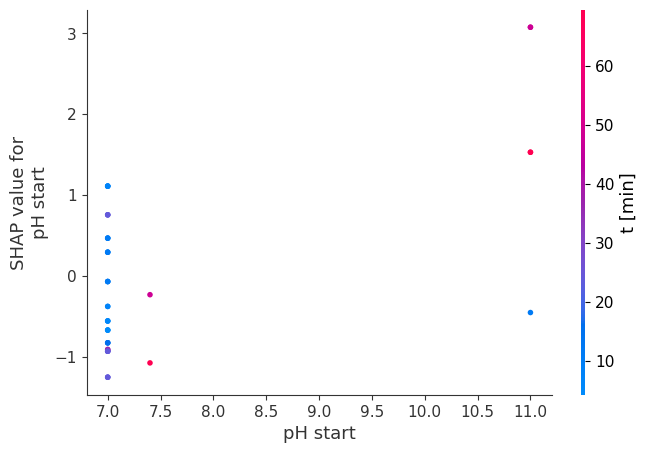

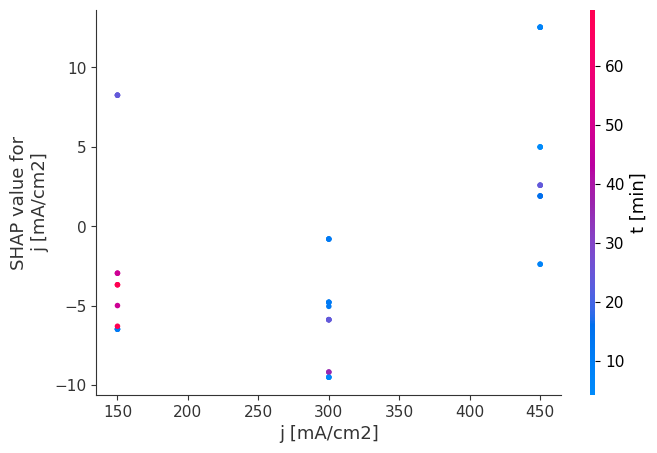

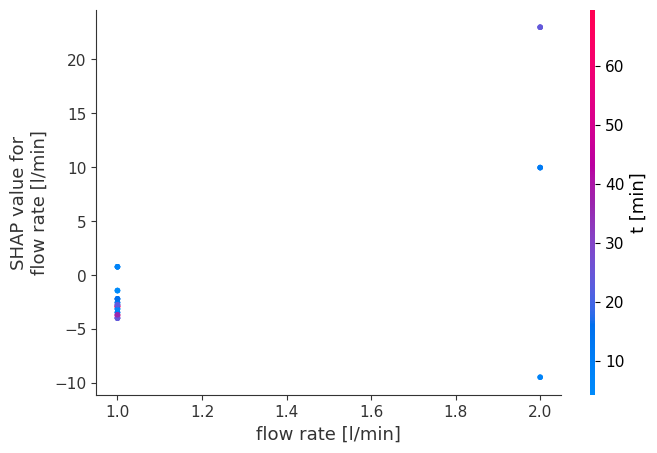

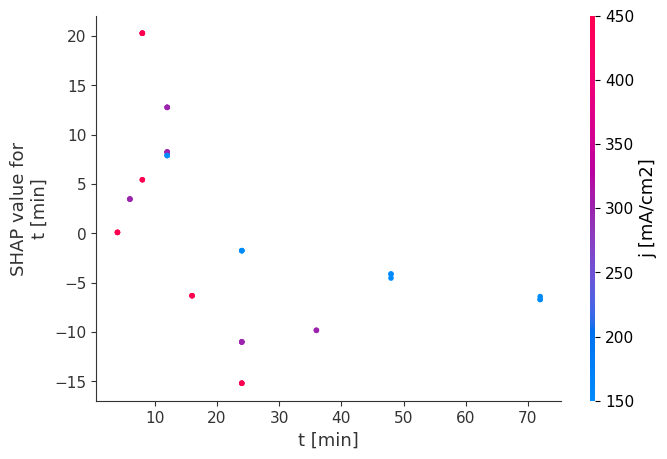

In [12]:
# Create a SHAP dependence plot

for i in features:
    shap.dependence_plot(i, shap_values, shap_data, feature_names=feature_names)

In [13]:
df_test=pd.DataFrame({"test": Y_test, "prediction": Y_predict_test_knn})
print(df_test)

        test  prediction
0  40.751131   41.307222
1  35.705871   36.634238
2  29.477309   33.705261
3  33.202675   35.999925
4  61.808607   61.276212
5  25.646644   33.705261
6  48.370689   61.276212
7  28.278815   31.638331
8  49.275741   41.307222


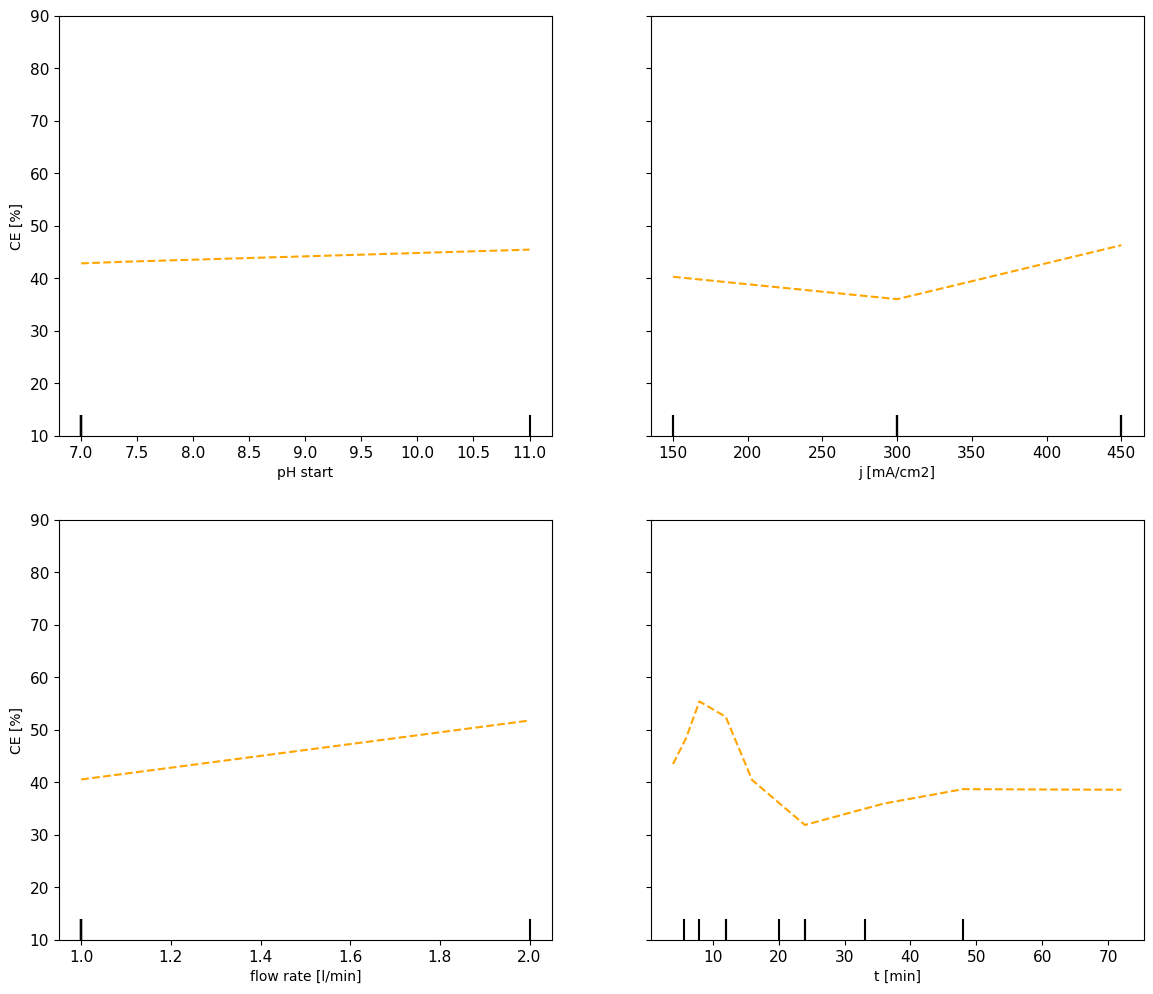

In [14]:
ax_labelsize = 24
tick_labelsize = 11

nrows = 2 
ncols = 2 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 12))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis



y_label = output_name    
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)

display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, ax=ax, line_kw={"color": "orange", "linestyle": "--"})

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
    axis.set_yticks(np.arange(10, 91, 10)) # y axis intervall

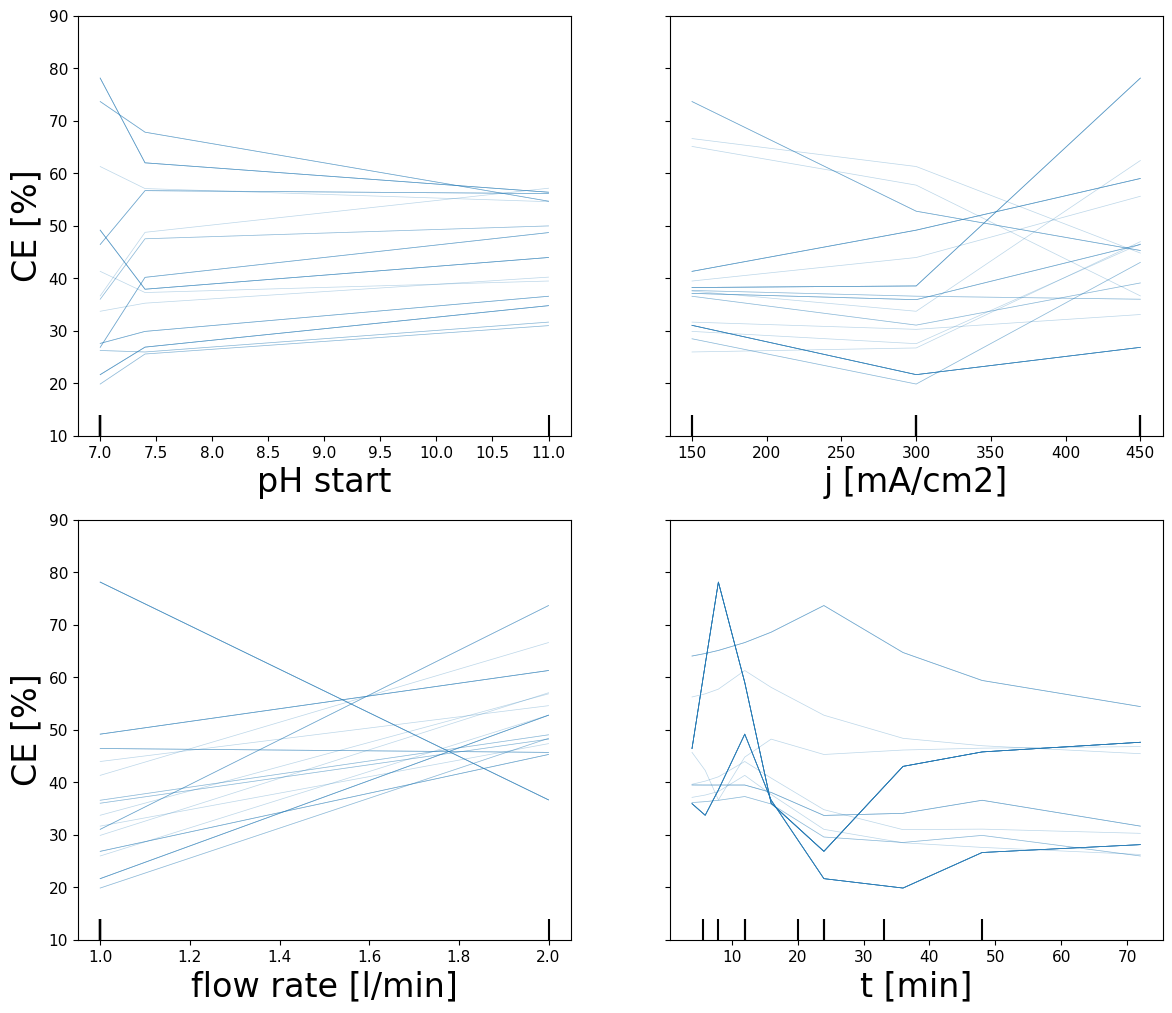

In [15]:
#  Individual conditional expectation (ICE) plot (single instead of averages) 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 12))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

 
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)

features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']
display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='individual', ax=ax)

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
    axis.set_yticks(np.arange(10, 91, 10)) # y axis intervall

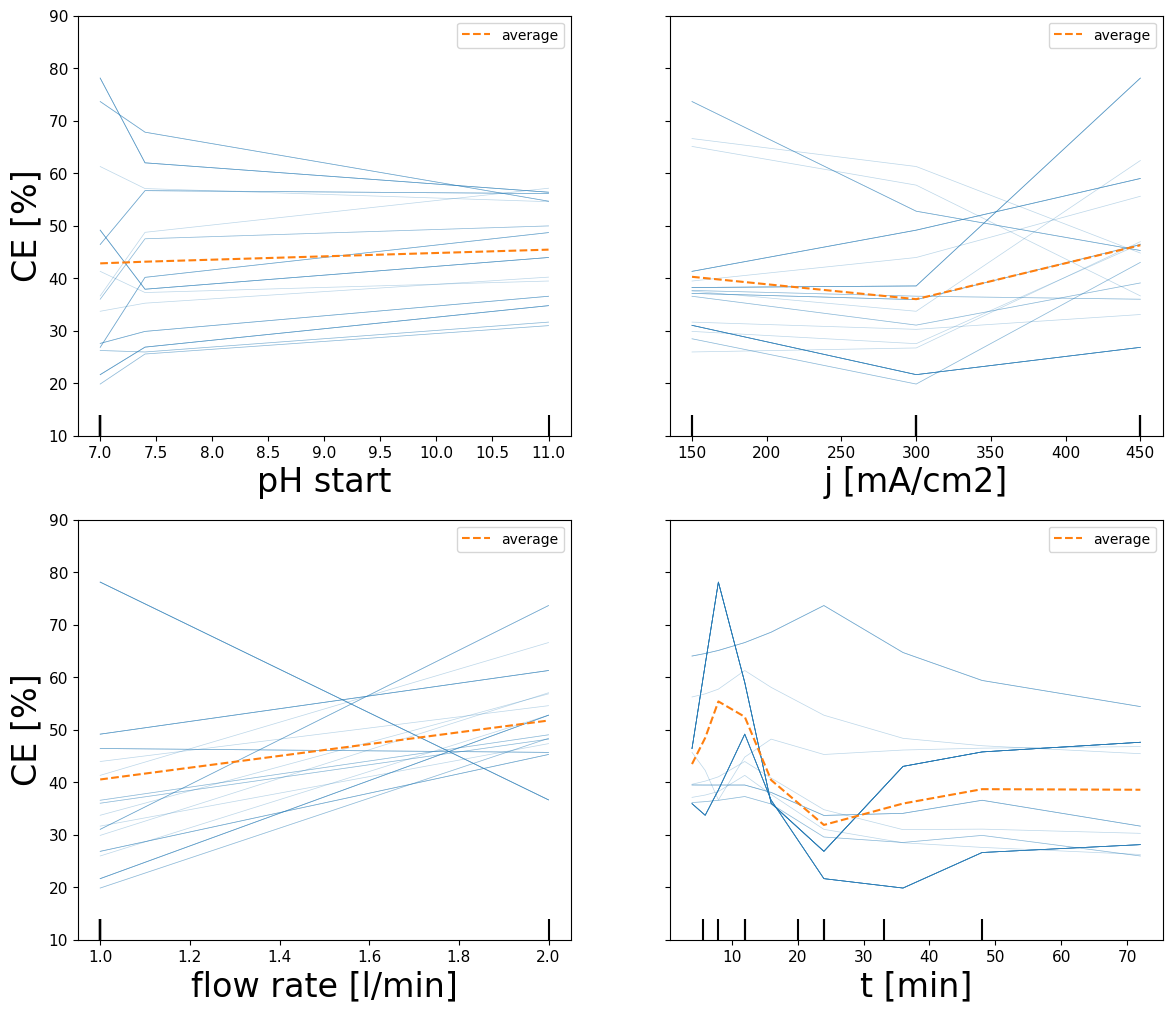

In [16]:
# cICE (centered ICE) and PDP
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 12))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

  
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)

features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']
display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', ax=ax)

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
    axis.set_yticks(np.arange(10, 91, 10)) # y axis intervall

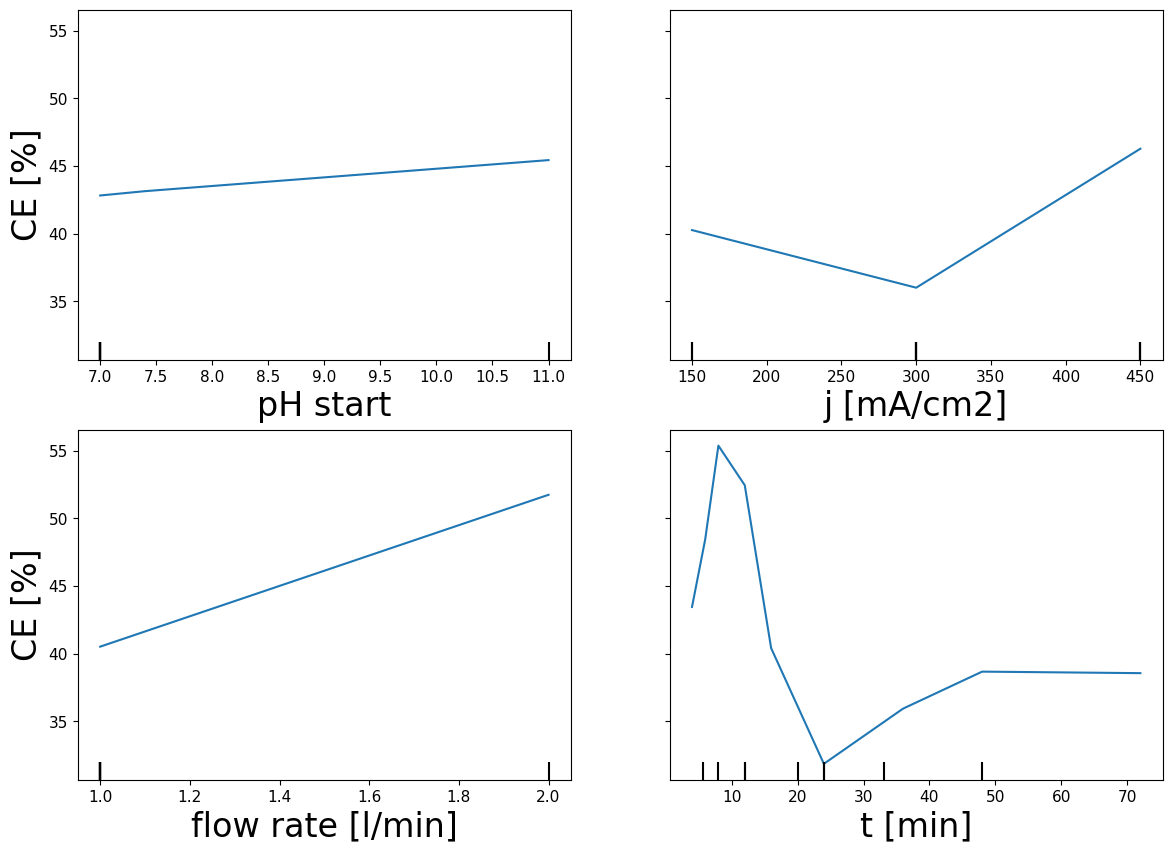

In [17]:
nrows = 2 
ncols = 2 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name   
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)


display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, ax=ax#, line_kw={"color": "green"}
                                                 )

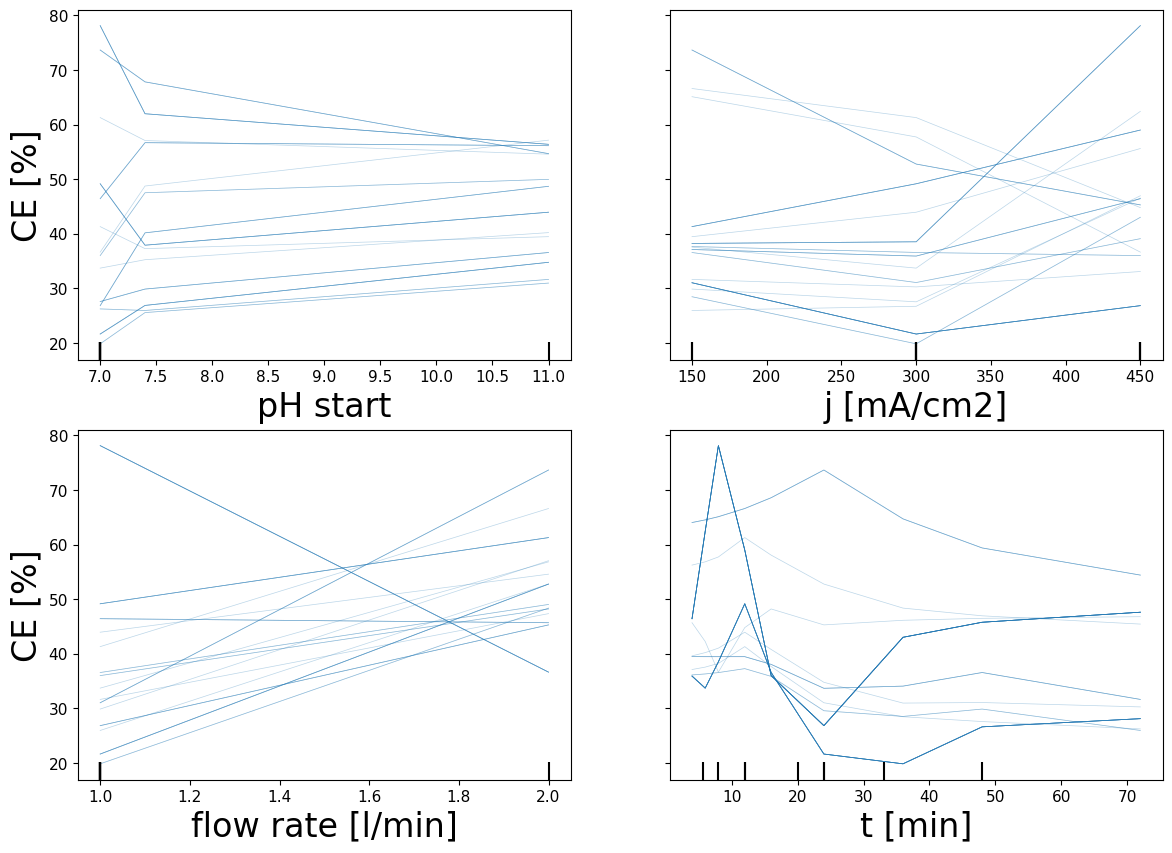

In [18]:
#  Individual conditional expectation (ICE) plot (single instead of averages) 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
 
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)

features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']
display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='individual', ax=ax)

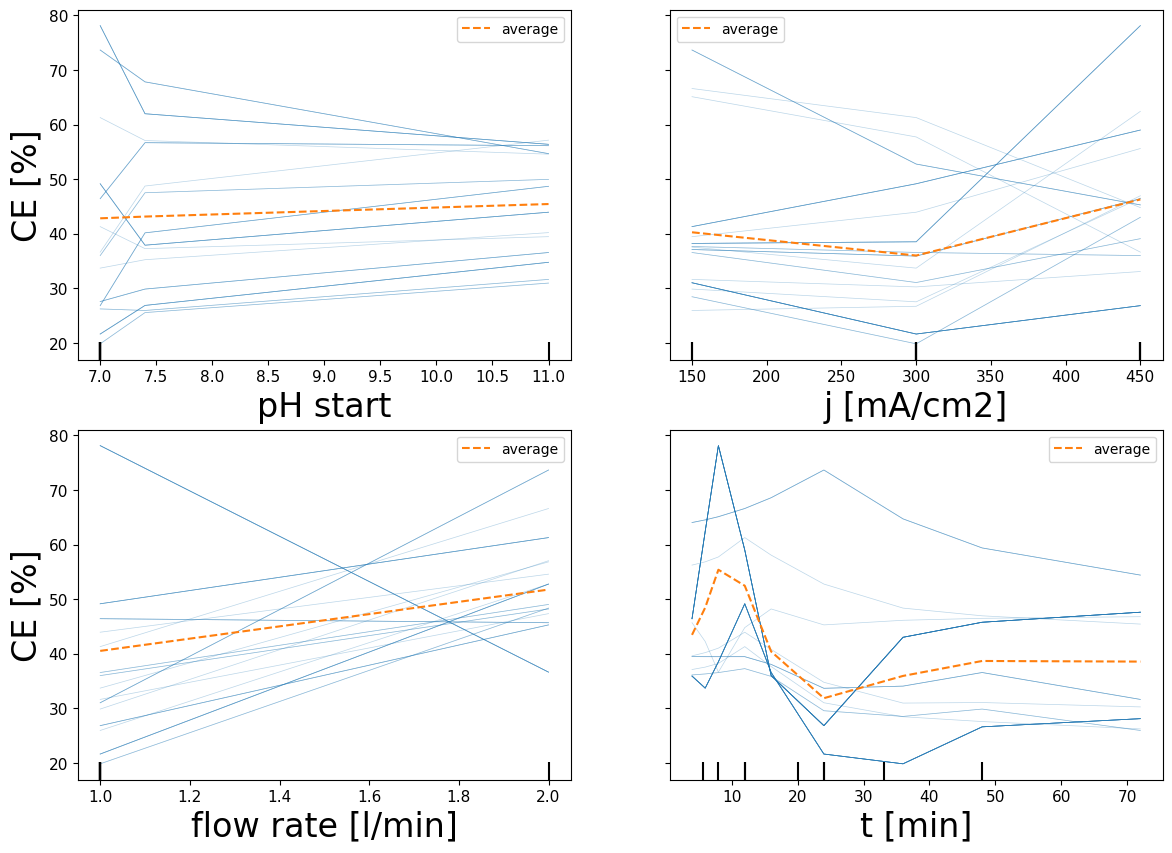

In [19]:
# cICE (centered ICE) and PDP
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 10))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
  
ax[0, 0].set_ylabel(y_label)
ax[1, 0].set_ylabel(y_label)

features = [0, 1, 2, 3]
feature_names = ['pH start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']
display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', ax=ax)

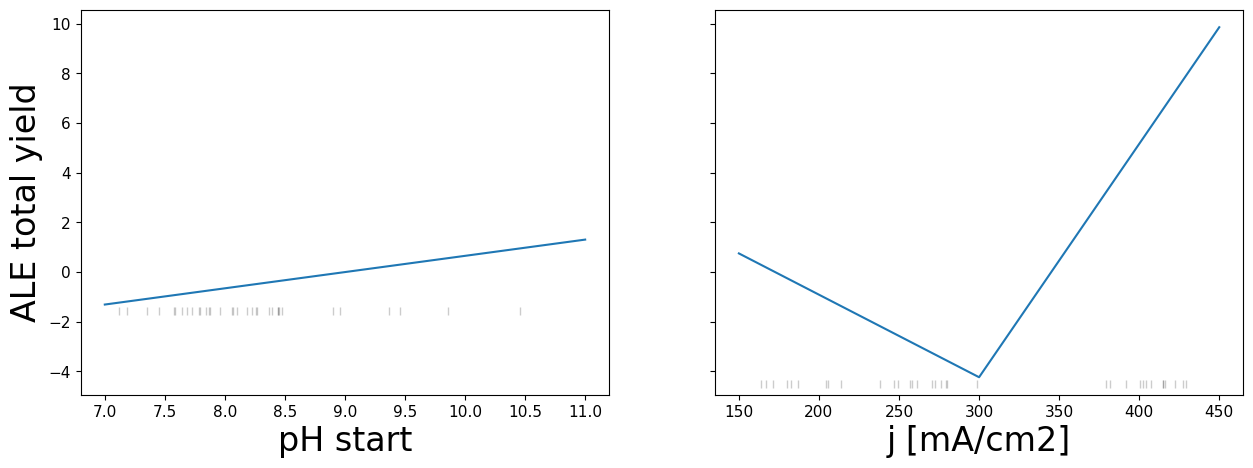

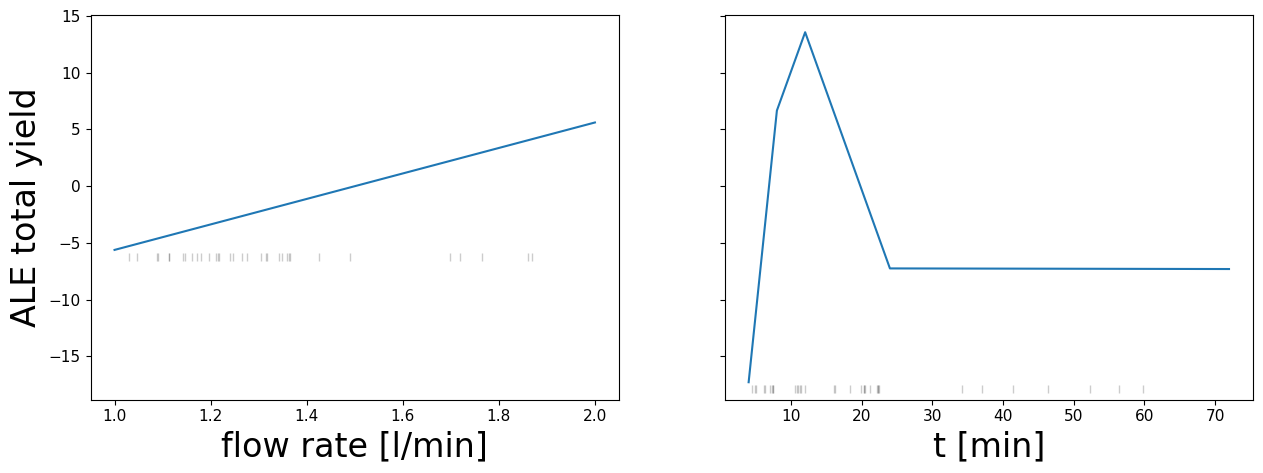

In [20]:
df_train_X = pd.DataFrame(X_train, columns=features)
df_train_Y = pd.DataFrame(Y_train, columns=['total_yield'])

# get ALE plot

for i in features:
    if i % 2 == 0:
        fig, ax = plt.subplots(ncols=ncols, figsize=(15, 5), sharey=True)
        for axis in ax.flatten():
            axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
        ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[0]
        )
        ax[0].set_ylabel('ALE total yield')
        ax[0].set_xlabel(feature_names[i])
        ax[0].set_title('')
    else:
        ale_eff = ale(
        X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
        fig=fig, ax=ax[1]
        )
        ax[1].set_ylabel('')
        ax[1].set_xlabel(feature_names[i])
        ax[1].set_title('')
    

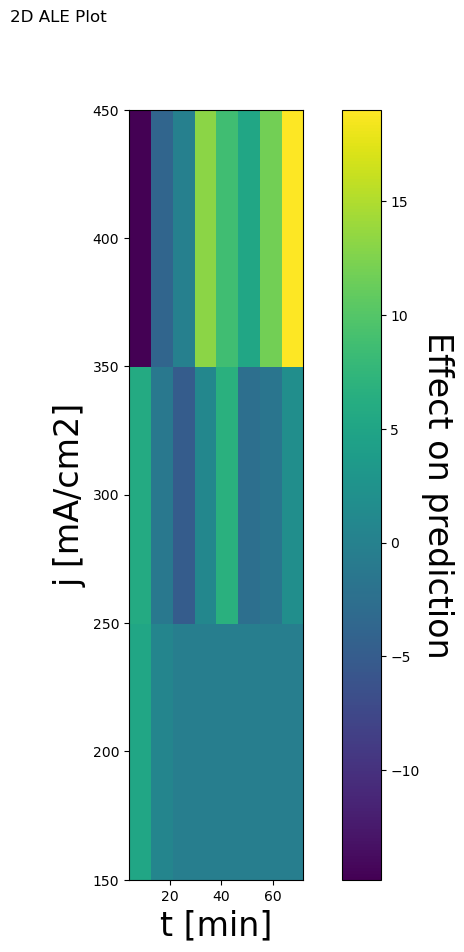

In [21]:
# 2D ale plots

df_train_X = pd.DataFrame(X_train, columns=feature_names)

#fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 20))
fig, ax = plt.subplots(figsize=(10, 10))
#for axis in ax.flatten():
#    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
#ale_eff = ale(
#    X=df_train_X, model=knn_regressor, feature=[feature_names[0], "t [min]"], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
#    fig=fig, ax=ax[0, 0]
#)
ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[feature_names[1], "t [min]"], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
    fig=fig, ax=ax#[0,1]
)
#ale_eff = ale(
#    X=df_train_X, model=knn_regressor, feature=[feature_names[2], "t [min]"], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
#    fig=fig, ax=ax[0,2]
#)
#ale_eff = ale(
#    X=df_train_X, model=knn_regressor, feature=[feature_names[0], feature_names[1]], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
#    fig=fig, ax=ax[1,0]
#)
#ale_eff = ale(
#    X=df_train_X, model=knn_regressor, feature=[feature_names[0], feature_names[2]], feature_type='continuous', grid_size=10, include_CI=False, #C=0.95,
#    fig=fig, ax=ax#[1,1]
#)
#ale_eff = ale(
#    X=df_train_X, model=knn_regressor, feature=[feature_names[2], feature_names[1]], grid_size=10, include_CI=False, #C=0.95,
#    fig=fig, ax=ax[1,2]
#)
#ax.set_ylabel('ALE total yield')
#ax.set_xlabel(feature_names[i])
#ax.set_title('')



               Mean   Std Dev
pH Start   0.021780  0.039243
j          0.264139  0.152025
flow rate  0.427359  0.190416
time       0.286722  0.147023


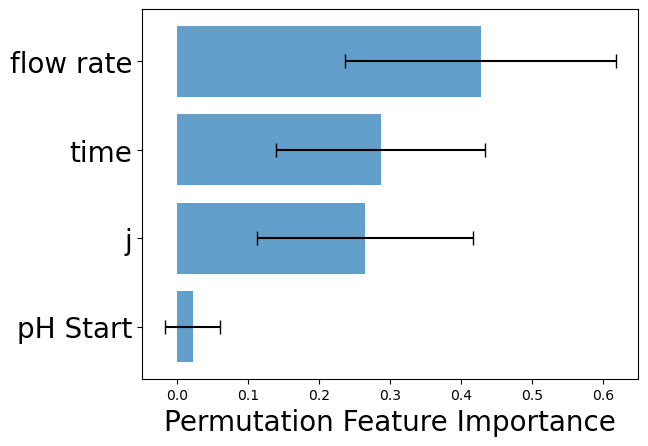

In [22]:
# permutation feature importance on test data

# Initialize data frame
df_feature_importances=pd.DataFrame(columns=['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]'])

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_test)
baseline_mse = mse(Y_test, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_test.shape[1])

runs = 500

for j in range(runs+1):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    df_feature_importances.loc[len(df_feature_importances)] = feature_importances

# Drop the first row after the loop as it is the same to the 2nd
df_feature_importances = df_feature_importances.drop(0, axis=0).reset_index(drop=True)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = ['pH Start', 'j', 'flow rate', 'time']

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(df_feature_importances.index)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names, fontsize=20)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance', fontsize=20)
plt.show()

                       Mean   Std Dev
pH Start           0.038371  0.024578
j [mA/cm2]         0.255360  0.064480
flow rate [l/min]  0.297825  0.069433
t [min]            0.408444  0.084587


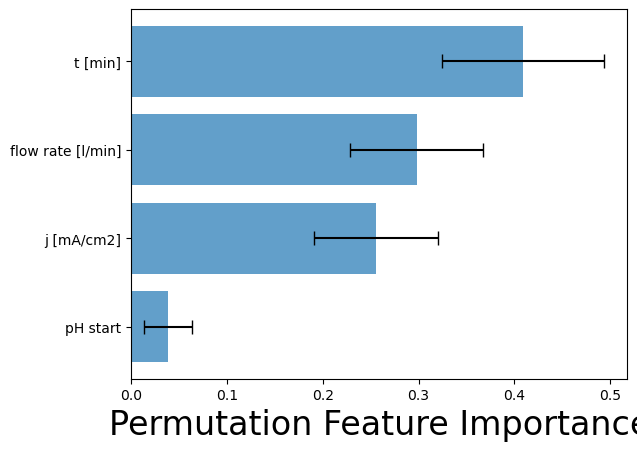

In [23]:
# permutation feature importance on training data

# Initialize data frame
df_feature_importances=pd.DataFrame(columns=['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]'])

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_train)
baseline_mse = mse(Y_train, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_train.shape[1])

runs = 500

for j in range(runs+1):
    
    # Perform permutation feature importance
    for i in range(X_train.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_train.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_train, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    df_feature_importances.loc[len(df_feature_importances)] = feature_importances

# Drop the first row after the loop as it is the same to the 2nd
df_feature_importances = df_feature_importances.drop(0, axis=0).reset_index(drop=True)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = ['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]']

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()

MSE on train set: 72.14757598435233
RMSE on train set: 8.493972921098367
R2 on train set: 0.8393376158140415
MSE on test set: 37.04802324070546
RMSE on test set: 6.086708736312709
R2 on test set: 0.7087525461578051


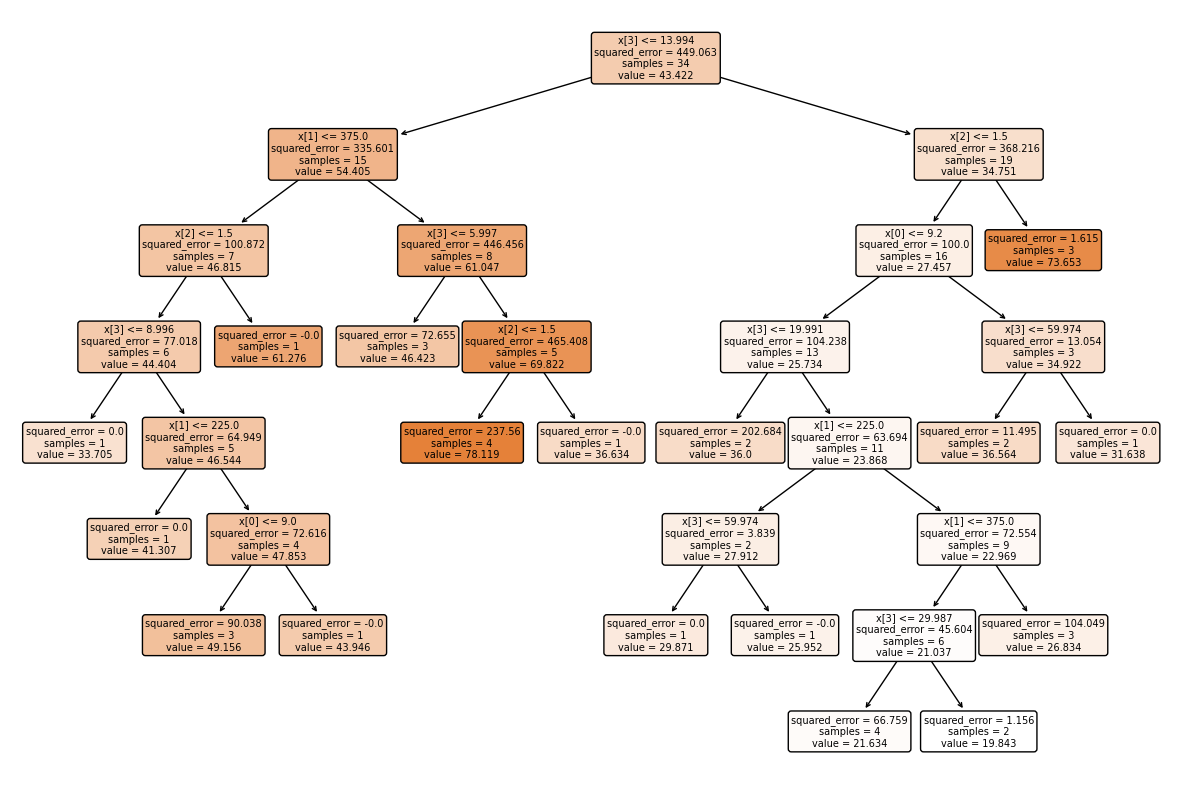

In [24]:
random_state_counter=43

# dt model
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_counter)

#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

#scaler = MinMaxScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

dt_regressor = DecisionTreeRegressor(max_depth=7)

dt_regressor.fit(X_train, Y_train)
Y_predict_train = dt_regressor.predict(X_train)
Y_predict_test = dt_regressor.predict(X_test)


mse_train = mean_squared_error(Y_train, Y_predict_train)
rmse_train = mean_squared_error(Y_train, Y_predict_train, squared=False)
r2_train = r2_score(Y_train, Y_predict_train)

mse_test = mean_squared_error(Y_test, Y_predict_test)
rmse_test = mean_squared_error(Y_test, Y_predict_test, squared=False)
r2_test = r2_score(Y_test, Y_predict_test)

print("MSE on train set:", mse_train)
print("RMSE on train set:", rmse_train)
print("R2 on train set:", r2_train)
print("MSE on test set:", mse_test)
print("RMSE on test set:", rmse_test)
print("R2 on test set:", r2_test)

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(dt_regressor, filled=True, rounded=True)
plt.show()

In [25]:
df_test_dt=pd.DataFrame({"test": Y_test, "prediction": Y_predict_test})
print(df_test_dt)

        test  prediction
0  40.751131   41.307222
1  35.705871   36.634238
2  29.477309   33.705261
3  33.202675   35.999925
4  61.808607   61.276212
5  25.646644   33.705261
6  48.370689   61.276212
7  28.278815   31.638331
8  49.275741   41.307222


               Mean   Std Dev
pH Start  -0.000811  0.000607
j          0.197113  0.130014
flow rate  0.464466  0.184658
time       0.339232  0.160959


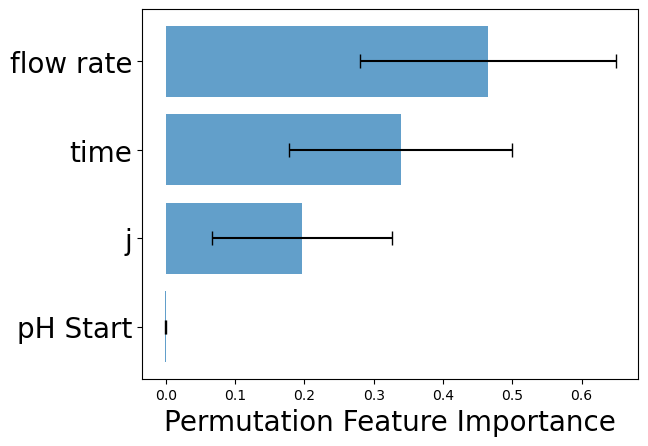

In [26]:
# permutation feature importance on test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_counter)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dt_regressor = DecisionTreeRegressor(max_depth=7)

dt_regressor.fit(X_train, Y_train)

# Initialize data frame
df_feature_importances=pd.DataFrame(columns=['pH Start', 'j [mA/cm2]', 'flow rate [l/min]', 't [min]'])

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = dt_regressor.predict(X_test)
baseline_mse = mse(Y_test, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_test.shape[1])

runs = 500

for j in range(runs+1):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = dt_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    df_feature_importances.loc[len(df_feature_importances)] = feature_importances

# Drop the first row after the loop as it is the same to the 2nd
df_feature_importances = df_feature_importances.drop(0, axis=0).reset_index(drop=True)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = ['pH Start', 'j', 'flow rate', 'time']

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(df_feature_importances.index)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names, fontsize=20)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance', fontsize=20)
plt.show()